In [1]:
!pip install kaggle opencv-python-headless scikit-learn matplotlib tensorflow

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

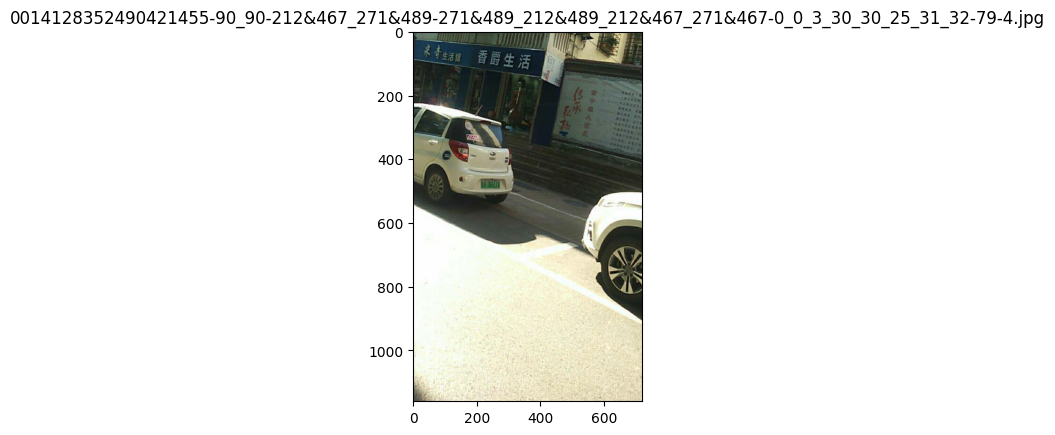

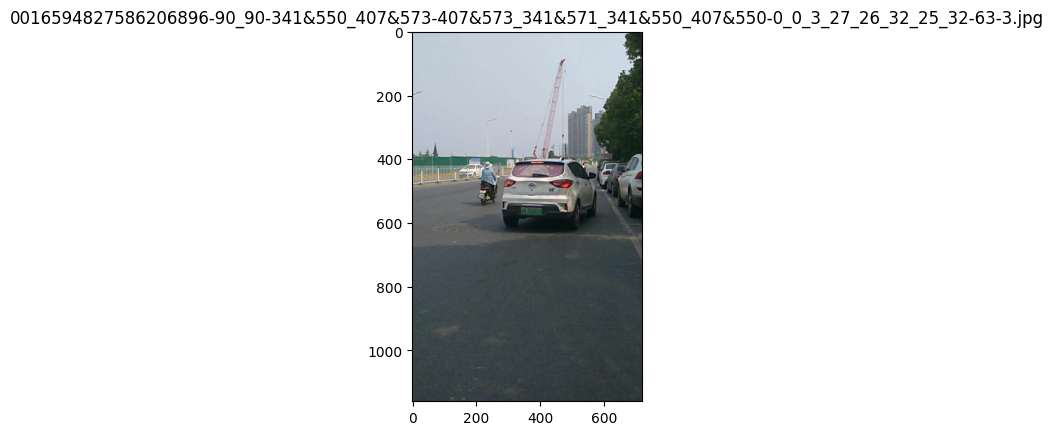

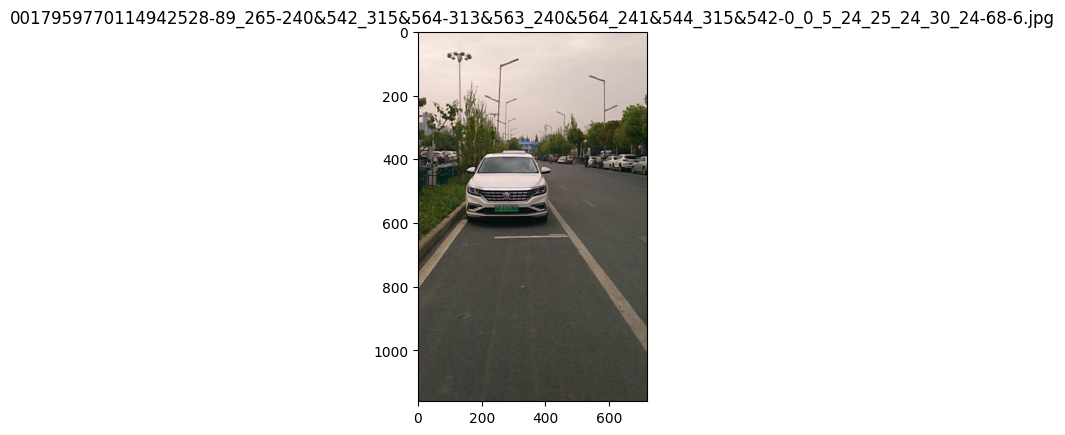

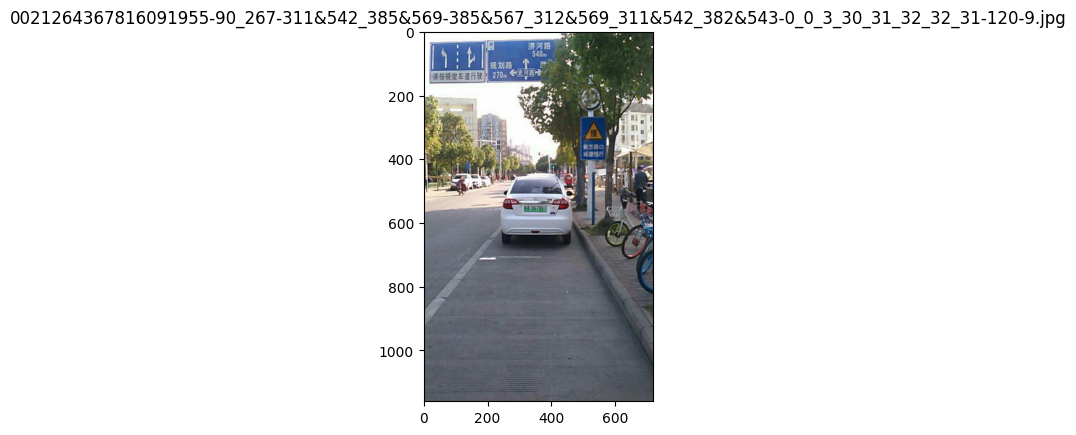

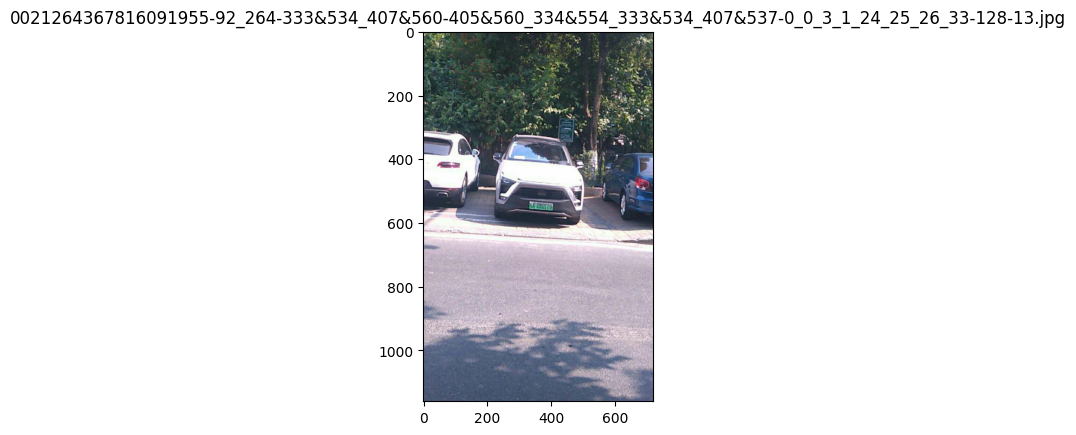

In [3]:
import os
from PIL import Image

dataset_path = 'CCPD2020/CCPD2020/ccpd_green/test'
sample_images = [f for f in os.listdir(dataset_path) if os.path.isfile(os.path.join(dataset_path, f))]
sample_images = sample_images[:5]

for img_name in sample_images:
    img = Image.open(os.path.join(dataset_path, img_name))
    plt.imshow(img)
    plt.title(img_name)
    plt.show()

In [4]:
import os
print(os.listdir(os.path.join('CCPD2020/CCPD2020/ccpd_green')))  # List files in the 'license_plates' folder


['test', 'train', 'val']


In [10]:
# Import required libraries for cv pipeline
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import os
from PIL import Image


In [28]:
def preprocess_image(image_path):
    # Read image
    img = cv2.imread(image_path)
    # Resize for consistency
    img = cv2.resize(img, (640, 480))
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    gray = clahe.apply(gray)
    # Apply bilateral filter
    bilateral = cv2.bilateralFilter(gray, 11, 17, 17)
    # Edge detection
    edges = cv2.Canny(bilateral, 50, 150)
    return img, gray, edges


def find_license_plate_contour(edges, original_img):
    contours, _ = cv2.findContours(edges.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

    location = None
    for contour in contours:
        peri = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.02 * peri, True)

        if len(approx) == 4:
            location = approx
            break

    if location is not None:
        mask = np.zeros(original_img.shape[:2], dtype=np.uint8)
        cv2.drawContours(mask, [location], 0, 255, -1)

        license_plate = cv2.bitwise_and(original_img, original_img, mask=mask)

        x, y, w, h = cv2.boundingRect(location)
        license_plate = license_plate[y:y+h, x:x+w]

        return license_plate, location
    return None, None


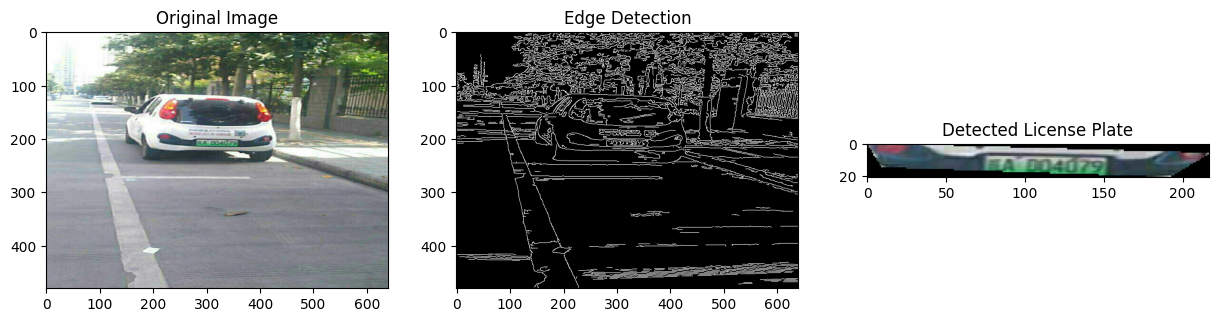

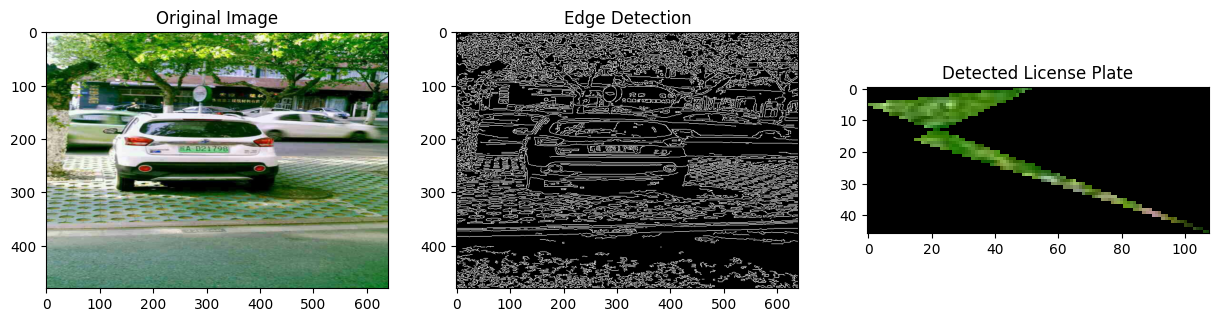

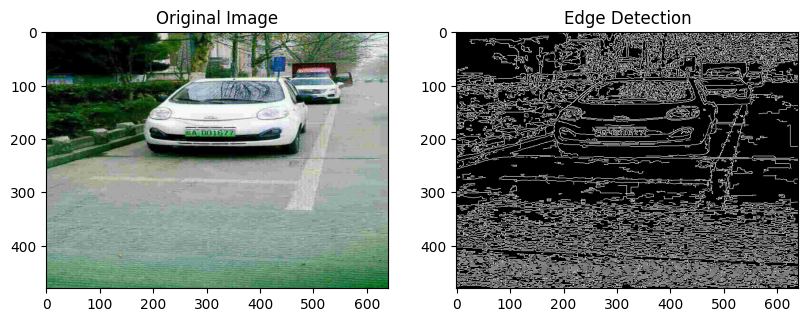

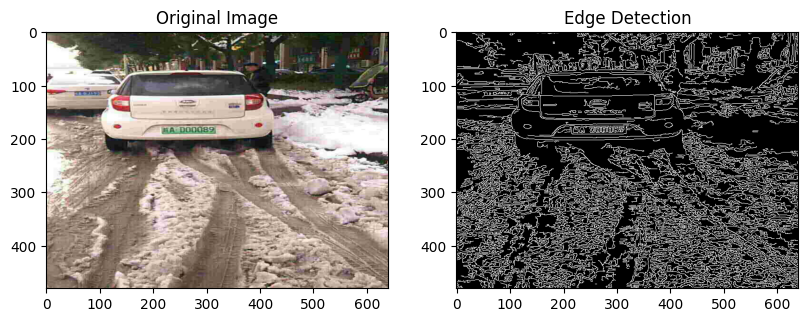

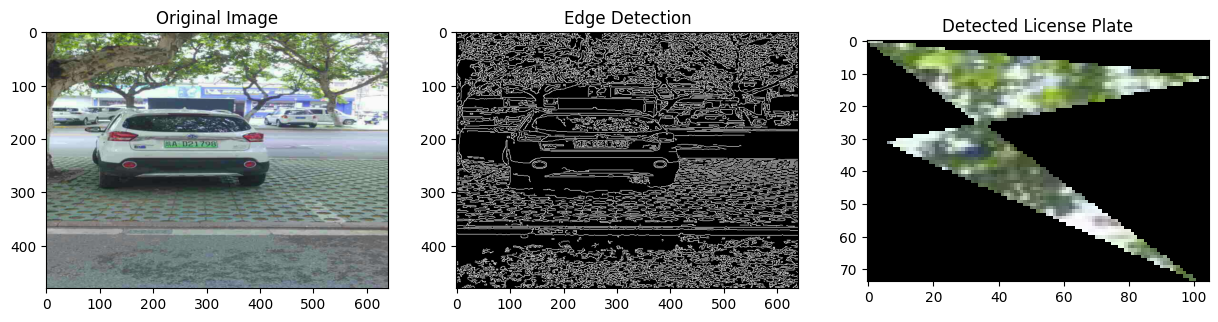

In [29]:
def process_sample_images(num_samples=5):
    dataset_path = 'CCPD2020/CCPD2020/ccpd_green/train'
    sample_images = [f for f in os.listdir(dataset_path) if f.endswith(('.jpg', '.jpeg', '.png'))][:num_samples]

    for img_name in sample_images:
        img_path = os.path.join(dataset_path, img_name)

        original, gray, edges = preprocess_image(img_path)
        plate, location = find_license_plate_contour(edges, original)
        plt.figure(figsize=(15, 5))

        plt.subplot(131)
        plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
        plt.title('Original Image')

        plt.subplot(132)
        plt.imshow(edges, cmap='gray')
        plt.title('Edge Detection')

        if plate is not None:
            plt.subplot(133)
            plt.imshow(cv2.cvtColor(plate, cv2.COLOR_BGR2RGB))
            plt.title('Detected License Plate')

        plt.show()

# Test the processing pipeline
process_sample_images()



In [20]:
def segment_characters(plate_image):
    if len(plate_image.shape) > 2:
        gray = cv2.cvtColor(plate_image, cv2.COLOR_BGR2GRAY)
    else:
        gray = plate_image

    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    char_boxes = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if w > 10 and h > 10:
            char_boxes.append((x, y, w, h))

    char_boxes.sort(key=lambda x: x[0])

    characters = []
    for box in char_boxes:
        x, y, w, h = box
        char_image = gray[y:y+h, x:x+w]
        char_image = cv2.resize(char_image, (32, 32))
        characters.append(char_image)

    return characters

def process_and_recognize_plate(plate_image):
    characters = segment_characters(plate_image)

    if len(characters) > 0:
        plt.figure(figsize=(15, 3))
        for i, char in enumerate(characters):
            plt.subplot(1, len(characters), i+1)
            plt.imshow(char, cmap='gray')
            plt.axis('off')
        plt.show()
    else:
        print("No characters were segmented from the license plate.")


License plate detected! Processing characters...


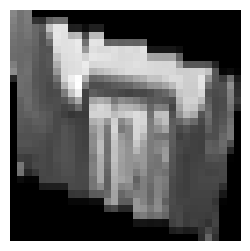

In [21]:
dataset_path = 'CCPD2020/CCPD2020/ccpd_green/train'
sample_images = [f for f in os.listdir(dataset_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

if len(sample_images) > 0:
    img_path = os.path.join(dataset_path, sample_images[0])
    original, gray, edges = preprocess_image(img_path)
    plate, location = find_license_plate_contour(edges, original)

    if plate is not None:
        print("License plate detected! Processing characters...")
        process_and_recognize_plate(plate)
    else:
        print("No license plate detected in the image.")
else:
    print("No images found in the dataset directory.")
